In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from neuroaging.utils.utils import compute_poststrat_weights

2025-06-08 19:42:22.975 | INFO     | neuroaging.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/neuroaging


In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [4]:
metric = "gm_vol"
metrics = [metric]
distribution_metric = "qfmean"

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig5") / ATLAS / metric
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})



# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1371172/1881232467.py:14: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [5]:
metric_cols = {metric: "volume" if metric == "gm_vol" else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df


In [6]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [7]:
# assign weights
for metric in metrics:
    data[metric]["subject_code"] = data[metric]["subject_code"].astype(str).str.zfill(4)

In [8]:
df = data[metrics[0]].drop_duplicates(subset=["subject_code"],keep="first").copy()

In [9]:
import pandas as pd

def group_by_age(df, age_col:str = "age_at_scan",n_bins:int=50):
    """
    Group participants by age into n_bins with equal number of participants.
    
    Parameters:
    - df: DataFrame containing the data
    - age_col: Column name for age
    - n_bins: Number of bins to create
    
    Returns:
    - DataFrame with an additional column for age groups
    """
    # Create age groups with equal number of participants
    df["age_group"] = pd.qcut(df[age_col], q=n_bins, labels=False)

    # Optional: Assign labels like "Q1", "Q2", etc.
    df["age_group_label"] = pd.qcut(
        df[age_col], q=n_bins, labels=[f"Q{i+1}" for i in range(n_bins)]
    )
    # Group by the age_group_label column
    group_stats = df.groupby("age_group_label")["age_at_scan"].agg(
        median_age="median", mean_age="mean", sd_age="std", n_participants="count"
    )

    # Merge stats back into original df
    return df.merge(group_stats, on="age_group_label", how="left")
    



In [10]:
# use sm.ols
import statsmodels.api as sm
import statsmodels.formula.api as smf

scns = {}
for metric in metrics:
    long_df = data[metric].copy()
    ages = group_by_age(long_df.drop_duplicates(subset="subject_code", keep="first"), age_col="age_at_scan", n_bins=50)
    age_group_map = ages[["subject_code", 'age_group_label', "age_at_scan"]]
    covariates = ["sex"] if metric != "gm_vol" else ["sex", "tiv"]

    # if metric == "gm_vol":
    #     long_df["value"] = long_df["value"] / long_df["tiv"]
    # correct for sex
    wide_df = long_df.pivot_table(index="subject_code", columns=[region_col], values="value")
    # residualise for sex, and if needed, for TIV
    for col in wide_df.columns:
        df_tmp = ages.set_index("subject_code").copy()
        df_tmp["value"] = wide_df[col]
        model = smf.ols(f"value ~ " + " + ".join(covariates), data=df_tmp).fit()
        wide_df[col] = model.resid + model.params["Intercept"]
        # break
    # break

    # Step 2: Add age group info to wide matrix
    for group_name, group_df in ages.groupby("age_group_label"):
        # Create a new column for each age group
        region_matrix = wide_df.loc[group_df["subject_code"]]
        corr_matrix = region_matrix.corr(method="pearson")
        scns[group_name] = {"corr_matrix": corr_matrix, "metadata": group_df}
        # break
    # wide_df = wide_df.merge(age_group_map, left_on="subject_code", right_on="subject_code")
    # wide_df = wide_df.merge(age_group_map, left_on="subject_code", right_on="subject_code")
    # break

/tmp/ipykernel_1371172/2905021287.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group"] = pd.qcut(df[age_col], q=n_bins, labels=False)
/tmp/ipykernel_1371172/2905021287.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group_label"] = pd.qcut(
/tmp/ipykernel_1371172/2905021287.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

In [11]:
age_group_map["age_group_label"].value_counts().reset_index()

age_group_label  count
0              Q10     48
1               Q8     46
2              Q12     46
3              Q24     46
4              Q15     45
5               Q1     45
6              Q17     45
7              Q16     45
8               Q6     45
9               Q3     45
10             Q36     45
11             Q28     45
12             Q29     45
13             Q33     45
14             Q27     45
15             Q23     45
16             Q21     45
17             Q39     45
18             Q37     45
19             Q45     45
20             Q50     45
21             Q48     45
22             Q42     45
23             Q46     44
24              Q7     44
25             Q13     44
26              Q2     44
27             Q41     44
28             Q31     44
29             Q34     44
30              Q5     44
31              Q4     44
32             Q30     44
33             Q19     44
34             Q47     44
35             Q44     44
36             Q35     44
37             Q43     44
38             Q22     44
39             Q20     44
40             Q25     44
41             Q40     44
42             Q49     44
43             Q18     43
44             Q14     43
45              Q9     43
46             Q38     43
47             Q32     43
48             Q26     42
49             Q11     40

Text(0.5, 1.0, 'Distribution of participants across age groups')

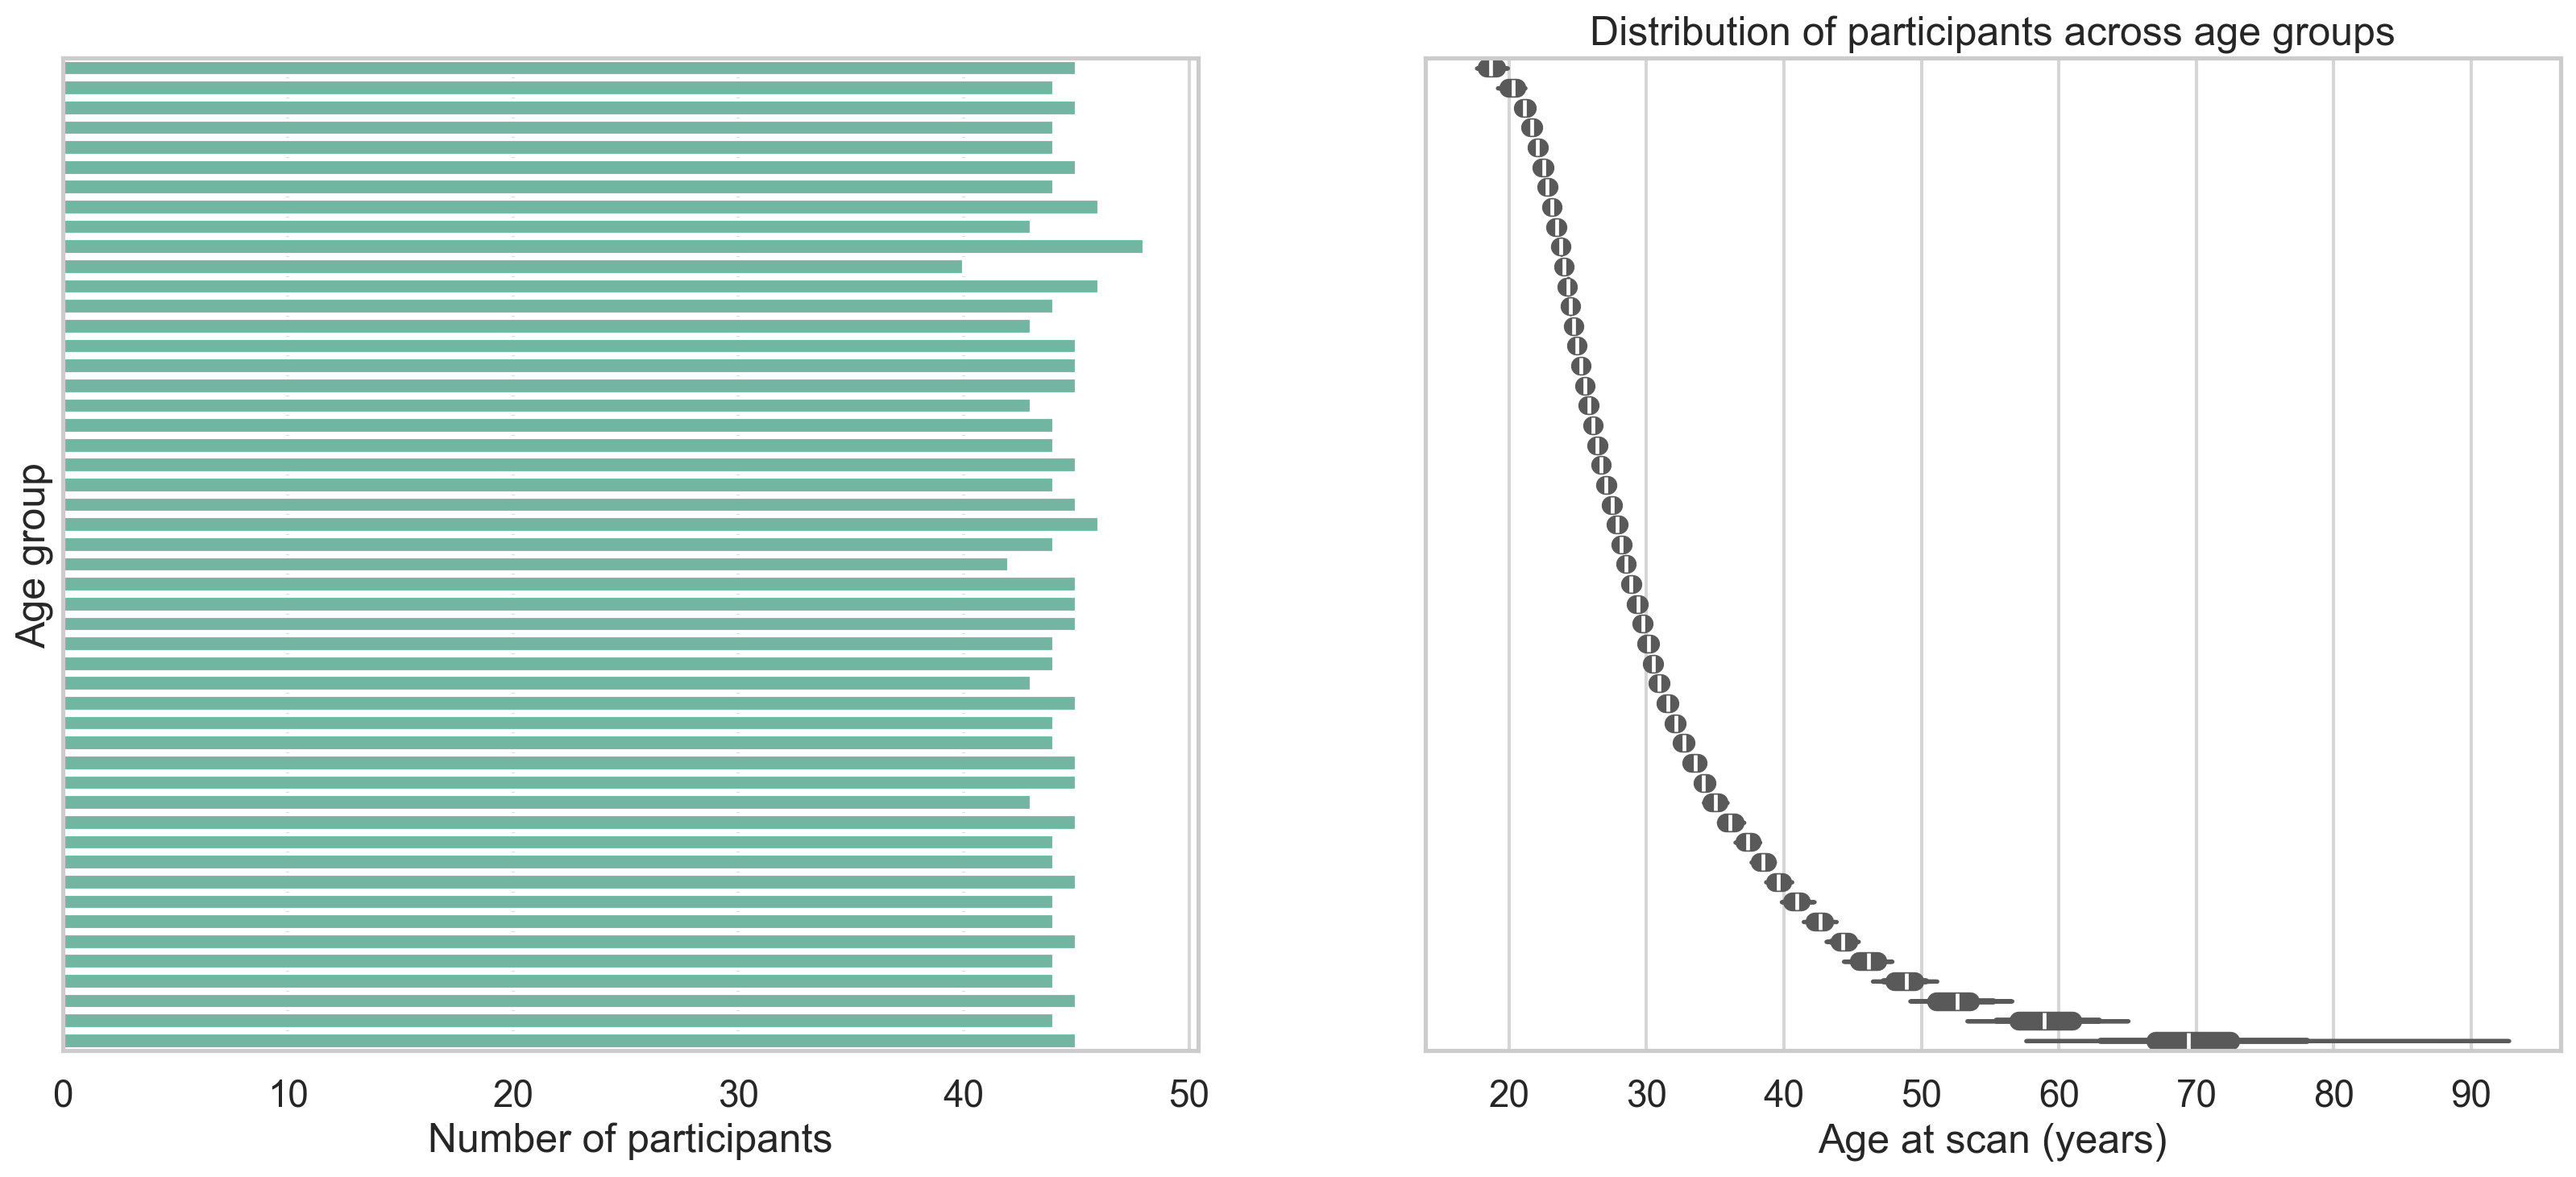

In [12]:
import seaborn as sns

# age_group_map

fig,axes = plt.subplots(1,2, figsize=(20, 8), sharey=True)
ax = sns.barplot(
    data=age_group_map["age_group_label"].value_counts().reset_index(),
    y="age_group_label",
    x="count",
    ax=axes[0],
    
)

ax.set_xlabel("Number of participants")
ax.set_ylabel("Age group")

ax = sns.violinplot(
    data=age_group_map,
    y="age_group_label",
    x="age_at_scan",
    ax=axes[1]
)

ax.set_xlabel("Age at scan (years)")

# remove y ticks
ax.set_yticks([])
ax.set_title("Distribution of participants across age groups")



In [13]:
import bct
from tqdm import tqdm
import networkx as nx

network_matrices_dict = {}

FORCE = False

metrics_directory = OUTPUT_DIR / "network_matrices"
metrics_directory.mkdir(parents=True, exist_ok=True)

for group_name, group_data in tqdm(scns.items(), desc="Calculating network matrices"):
    target_file = metrics_directory / f"{group_name}.csv"
    if not FORCE and target_file.exists():
        print(f"Loading existing file: {target_file}")
        p = pd.read_csv(target_file, index_col=0)
        network_matrices_dict[group_name] = p
        continue
    # break

network_matrices = pd.concat(network_matrices_dict.values(), ignore_index=True)

Calculating network matrices: 100%|██████████| 50/50 [00:00<00:00, 604.46it/s]

Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian2020_400_7/gm_vol/network_matrices/Q1.csv
Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian2020_400_7/gm_vol/network_matrices/Q2.csv
Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian2020_400_7/gm_vol/network_matrices/Q3.csv
Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian2020_400_7/gm_vol/network_matrices/Q4.csv
Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian2020_400_7/gm_vol/network_matrices/Q5.csv
Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian2020_400_7/gm_vol/network_matrices/Q6.csv
Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian2020_400_7/gm_vol/network_matrices/Q7.csv
Loading existing file: /home/galkepler/Projects/neuroaging/figures/fig5/schaefer2018tian20

In [14]:
network_matrices["index"] = parcels["index"].values.tolist() * len(network_matrices["group"].unique())

In [15]:
network_matrices["weight"],_ = compute_poststrat_weights(
    network_matrices,
    israel_population,
    age_col="median_age",
    cap=None,  # try None first; if still spiky, use 4 or 5
    return_bin_table=True)

In [16]:
# do ols using statsmodels smf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests


stats = {key: parcels.copy() for key in ["strength", "degree", "betweenness", "clustering"]}
for key, s in stats.items():
    # correlate between each metric and age
    for i, row in parcels.iterrows():
        # Prepare the data for OLS regression
        X_full = network_matrices.loc[network_matrices[region_col] == row[region_col]]
        y = X_full[key]
        age_vec = X_full["median_age"].astype(float)
        lin_model = smf.wls(f"{key} ~ median_age", data=X_full, weights=X_full["weight"]).fit()
        quad_model = smf.wls(f"{key} ~ median_age + I(median_age ** 2)", data=X_full, weights=X_full["weight"]).fit()
        # X = sm.add_constant(age_vec)
        # Fit the OLS model
        # lin_model = sm.OLS(y, X).fit()
        # quad_model = sm.OLS(y, sm.add_constant(np.column_stack((age_vec, age_vec**2)))).fit()
        # Store the results
        s.loc[i, "beta1"] = lin_model.params[1]
        s.loc[i, "intercept"] = lin_model.params[0]
        s.loc[i, "pval"] = lin_model.f_pvalue
        s.loc[i, "adj_r2"] = lin_model.rsquared_adj
        s.loc[i, "quad_beta2"] = quad_model.params[2]
        s.loc[i, "quad_beta1"] = quad_model.params[1]
        s.loc[i, "quad_intercept"] = quad_model.params[0]
        s.loc[i, "quad_pval"] = quad_model.f_pvalue
        s.loc[i, "quad_adj_r2"] = quad_model.rsquared_adj
        # compare the models
        f, p, _ = quad_model.compare_f_test(lin_model)
        s.loc[i, "f_statistic"] = f
        s.loc[i, "pval_quad_vs_linear"] = p
        # break
    s["pval_adj"] = multipletests(s["pval"], method="fdr_bh")[1]
    s["quad_pval_adj"] = multipletests(s["quad_pval"], method="fdr_bh")[1]
    s["pval_quad_vs_linear_adj"] = multipletests(s["pval_quad_vs_linear"], method="fdr_bh")[1]
    # break

/tmp/ipykernel_1371172/3996247213.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "beta1"] = lin_model.params[1]
/tmp/ipykernel_1371172/3996247213.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "intercept"] = lin_model.params[0]
/tmp/ipykernel_1371172/3996247213.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "quad_beta2"] = quad_model.params[2]
/tmp/ipykernel_1371172/3996247213.py:27: Futu

In [17]:
s.sort_values(by="pval_adj", ascending=True).head(20)

index                                   name  \
420    421                                lAMY-rh   
167    168             7Networks_LH_Default_PFC_3   
448    449                                mAMY-lh   
193    194         7Networks_LH_Default_pCunPCC_5   
295    296  7Networks_RH_SalVentAttn_TempOccPar_3   
4        5                     7Networks_LH_Vis_5   
421    422                                mAMY-rh   
82      83          7Networks_LH_DorsAttn_Post_15   
447    448                                lAMY-lh   
333    334                7Networks_RH_Cont_Par_3   
3        4                     7Networks_LH_Vis_4   
25      26                    7Networks_LH_Vis_26   
116    117              7Networks_LH_Limbic_OFC_4   
222    223                    7Networks_RH_Vis_23   
400    401                         HIP-head-m1-rh   
364    365             7Networks_RH_Default_Par_4   
163    164             7Networks_LH_Default_Par_6   
95      96     7Networks_LH_SalVentAttn_TempOcc_1   
10      11                    7Networks_LH_Vis_11   
27      28                    7Networks_LH_Vis_28   

                               base_name                           Label Name  \
420                                 lAMY            Amygdala, lateral nucleus   
167             7networks_lh_default_pfc             7Networks_LH_Default_PFC   
448                                 mAMY             Amygdala, medial nucleus   
193         7networks_lh_default_pcunpcc         7Networks_LH_Default_pCunPCC   
295  7networks_rh_salventattn_tempoccpar  7Networks_RH_SalVentAttn_TempOccPar   
4                       7networks_lh_vis                     7Networks_LH_Vis   
421                                 mAMY             Amygdala, medial nucleus   
82            7networks_lh_dorsattn_post           7Networks_LH_DorsAttn_Post   
447                                 lAMY            Amygdala, lateral nucleus   
333                7networks_rh_cont_par                7Networks_RH_Cont_Par   
3                       7networks_lh_vis                     7Networks_LH_Vis   
25                      7networks_lh_vis                     7Networks_LH_Vis   
116              7networks_lh_limbic_ofc              7Networks_LH_Limbic_OFC   
222                     7networks_rh_vis                     7Networks_RH_Vis   
400                          HIP-head-m1    Hippocampus head, medial division   
364             7networks_rh_default_par             7Networks_RH_Default_Par   
163             7networks_lh_default_par             7Networks_LH_Default_Par   
95      7networks_lh_salventattn_tempocc     7Networks_LH_SalVentAttn_TempOcc   
10                      7networks_lh_vis                     7Networks_LH_Vis   
27                      7networks_lh_vis                     7Networks_LH_Vis   

                          network                             component  \
420                     subcortex                              Amygdala   
167                       default                     prefrontal cortex   
448                     subcortex                              Amygdala   
193                       default  precuneus posterior cingulate cortex   
295  salience / ventral attention           temporal occipital parietal   
4                          visual                                visual   
421                     subcortex                              Amygdala   
82               dorsal attention                             posterior   
447                     subcortex                              Amygdala   
333                       control                              parietal   
3                          visual                                visual   
25                         visual                                visual   
116                        limbic                orbital frontal cortex   
222                        visual                                visual   
400                     subcortex                      Hippocamp

Linear model summary:
                            WLS Regression Results                            
Dep. Variable:      global_efficiency   R-squared:                       0.276
Model:                            WLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     18.31
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           8.91e-05
Time:                        19:43:17   Log-Likelihood:                 600.31
No. Observations:                  50   AIC:                            -1197.
Df Residuals:                      48   BIC:                            -1193.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.222e-06   4.89e-

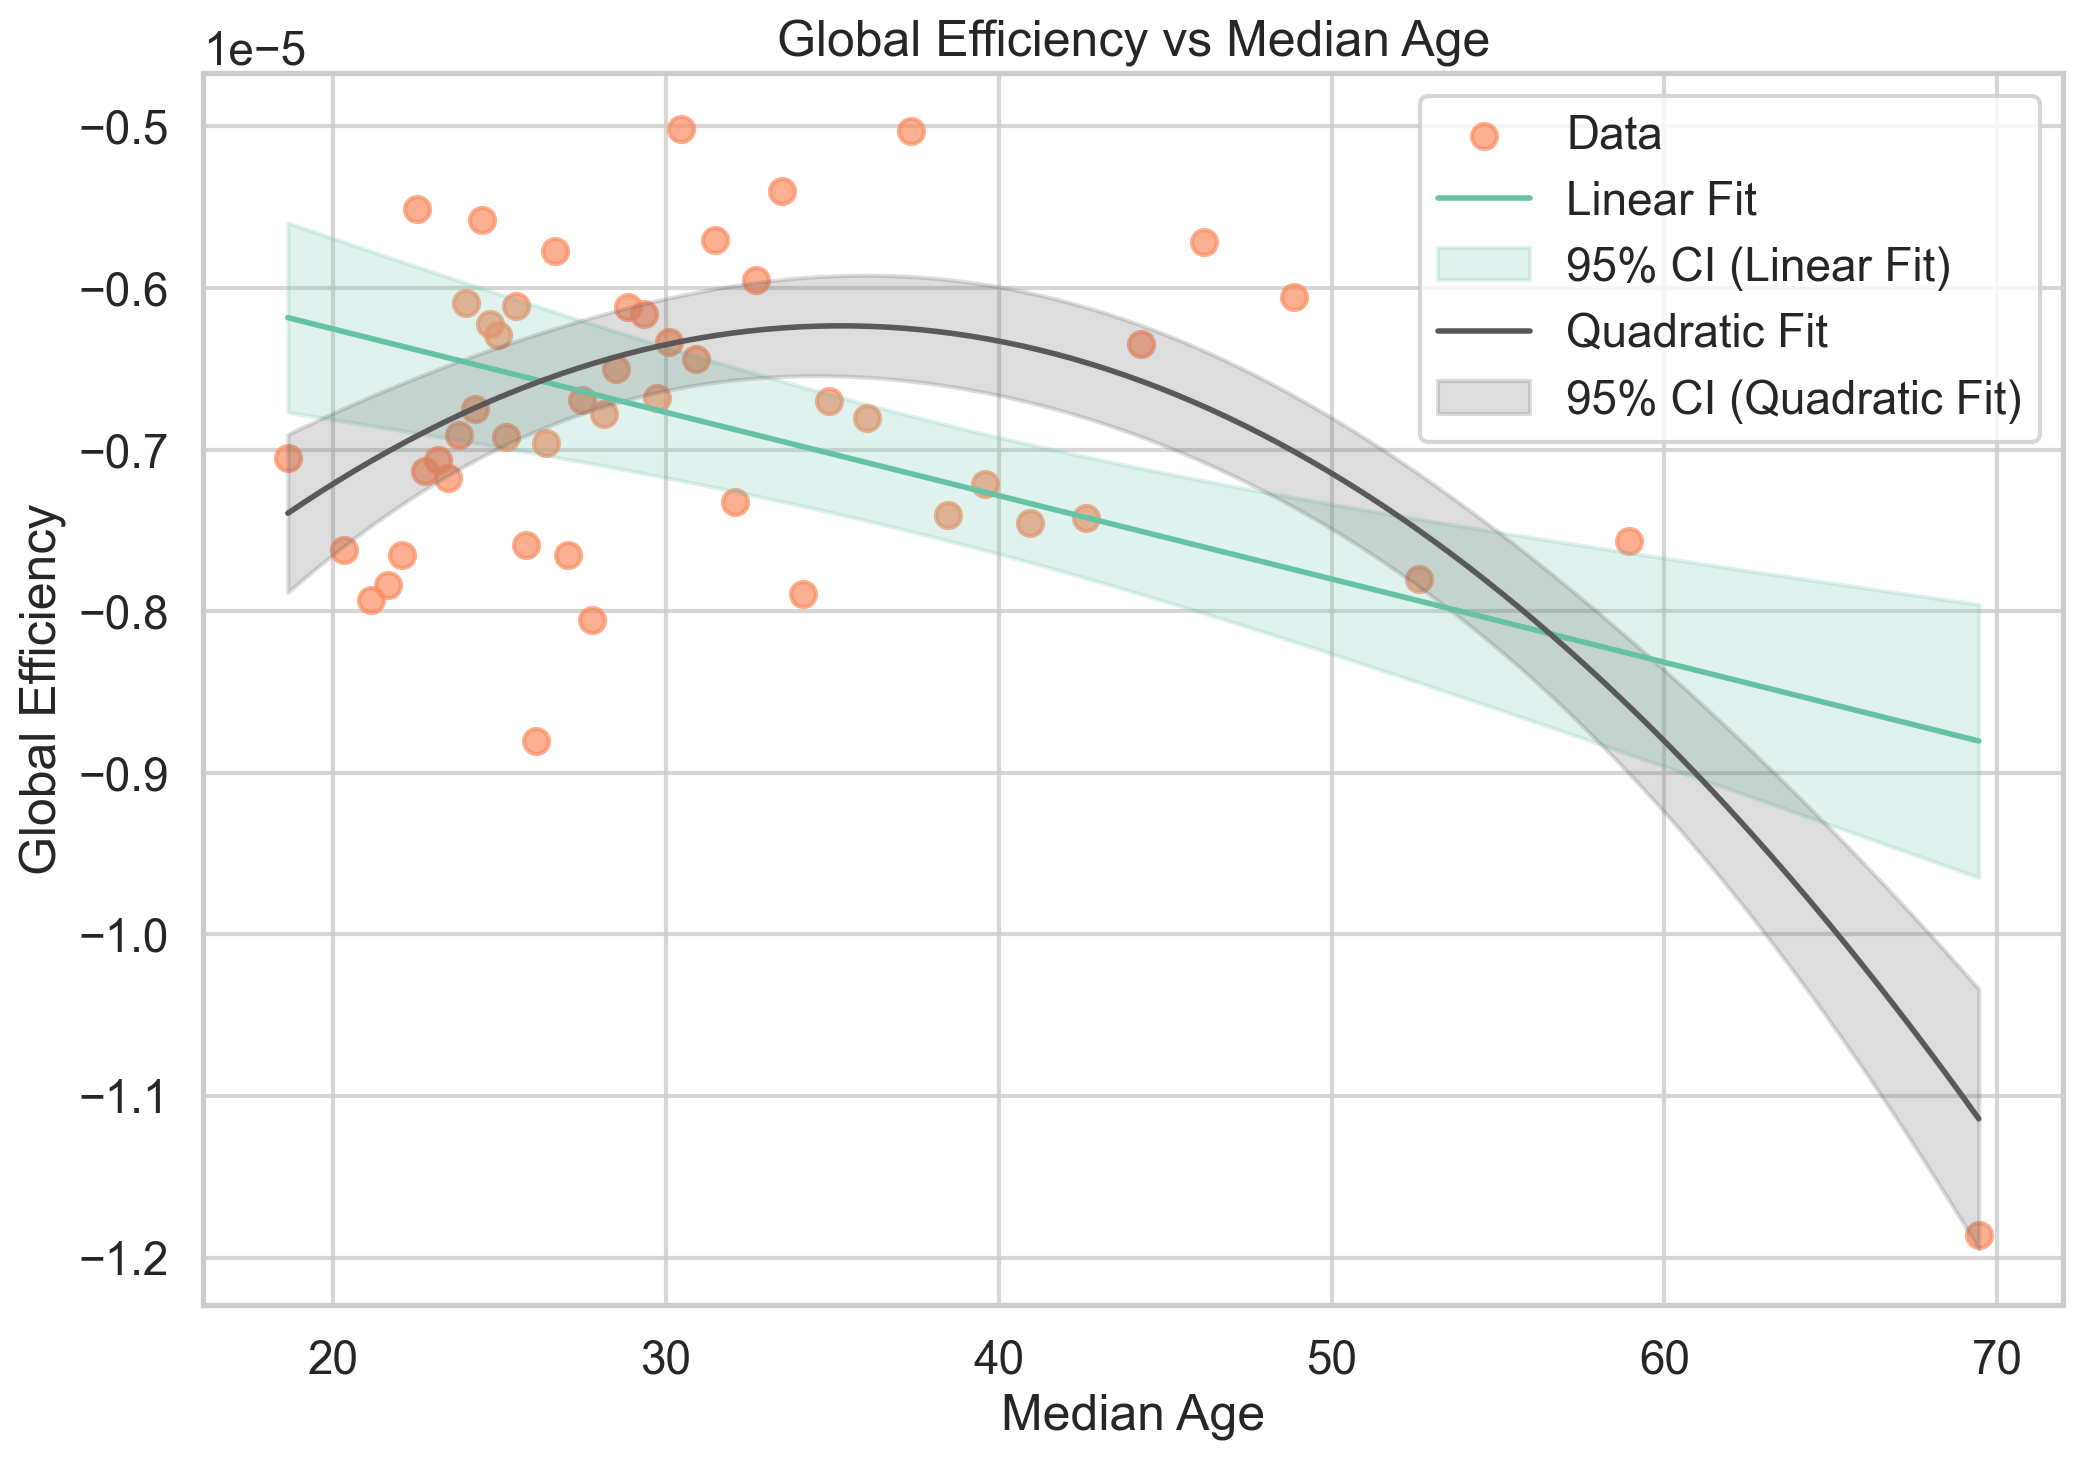

In [18]:
d = network_matrices.groupby("group").first()
lin_m = smf.wls("global_efficiency ~ median_age", data=d, weights=d["weight"]).fit()
quad_m = smf.wls("global_efficiency ~ median_age + I(median_age ** 2)", data=d, weights = d["weight"]).fit()
print("Linear model summary:")
print(lin_m.summary())
print("Quadratic model summary:")
print(quad_m.summary())

# plot global_efficiency vs median age with the fitted lines
plt.figure(figsize=(12, 8))
plt.scatter(d["median_age"], d["global_efficiency"], label="Data", color=COL_WEIGHTED, alpha=0.7)
# Plot linear fit
d_pred = pd.DataFrame({
    "median_age": np.linspace(d["median_age"].min(), d["median_age"].max(), 100)
})
pred_lin = lin_m.get_prediction(sm.add_constant(d_pred["median_age"]))
pred_lin_ci = pred_lin.conf_int()
plt.plot(d_pred["median_age"], lin_m.predict(sm.add_constant(d_pred["median_age"])), label="Linear Fit", color=COL_RAW, linewidth=2)
plt.fill_between(d_pred["median_age"], pred_lin_ci[:, 0], pred_lin_ci[:, 1], color=COL_RAW, alpha=0.2, label="95% CI (Linear Fit)")
# Plot quadratic fit
d_pred_quad = pd.DataFrame({
    "median_age": np.linspace(d["median_age"].min(), d["median_age"].max(), 100)
})
d_pred_quad["median_age_squared"] = d_pred_quad["median_age"] ** 2
pred_quad = quad_m.get_prediction(sm.add_constant(d_pred_quad))
pred_quad_ci = pred_quad.conf_int()
plt.plot(d_pred_quad["median_age"], quad_m.predict(sm.add_constant(d_pred_quad)), label="Quadratic Fit", color=COL_REF, linewidth=2)
plt.fill_between(d_pred_quad["median_age"], pred_quad_ci[:, 0], pred_quad_ci[:, 1], color=COL_REF, alpha=0.2, label="95% CI (Quadratic Fit)")
plt.xlabel("Median Age")
plt.ylabel("Global Efficiency")
plt.title("Global Efficiency vs Median Age")
plt.legend()
plt.grid(True)



# plt.plot(x, lin_m.predict(sm.add_constant(x)), label="Linear Fit", color=COL_RAW, linewidth=2)
# Plot quadratic fit
# plt.plot(x, quad_m.predict(sm.add_constant(np.column_stack((x, x**2)))), label="Quadratic Fit", color=COL_REF, linewidth=2)
# plt.xlabel("Median Age")
# plt.ylabel("Global Efficiency")
# plt.title("Global Efficiency vs Median Age")
# plt.legend()
# plt.grid(True)

In [19]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [20]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region": [], "value": [], "Hemisphere": []}

key = "strength"  # or "betweenness", "clustering"s

vis_df = stats[key].copy()
p_column = "quad_pval"
value_column = "quad_adj_r2"

for i, row in vis_df.iterrows():
    label = row[region_col]
    if (row[p_column] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        value = row[value_column]
    else:
        value = np.nan
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            value_map[label] = value

vec = np.vectorize(lambda x: value_map.get(x, np.nan))
data_lh = vec(lh_parc)
data_rh = vec(rh_parc)

In [21]:
vis_df.sort_values("pval").head(20)

index                                name  \
95      96  7Networks_LH_SalVentAttn_TempOcc_1   
193    194      7Networks_LH_Default_pCunPCC_5   
25      26                 7Networks_LH_Vis_26   
420    421                             lAMY-rh   
29      30                 7Networks_LH_Vis_30   
167    168          7Networks_LH_Default_PFC_3   
116    117           7Networks_LH_Limbic_OFC_4   
153    154         7Networks_LH_Default_Temp_6   
190    191      7Networks_LH_Default_pCunPCC_2   
4        5                  7Networks_LH_Vis_5   
448    449                             mAMY-lh   
228    229                 7Networks_RH_Vis_29   
222    223                 7Networks_RH_Vis_23   
128    129             7Networks_LH_Cont_Par_3   
210    211                 7Networks_RH_Vis_11   
109    110      7Networks_LH_SalVentAttn_Med_4   
3        4                  7Networks_LH_Vis_4   
82      83       7Networks_LH_DorsAttn_Post_15   
10      11                 7Networks_LH_Vis_11   
364    365          7Networks_RH_Default_Par_4   

                            base_name                        Label Name  \
95   7networks_lh_salventattn_tempocc  7Networks_LH_SalVentAttn_TempOcc   
193      7networks_lh_default_pcunpcc      7Networks_LH_Default_pCunPCC   
25                   7networks_lh_vis                  7Networks_LH_Vis   
420                              lAMY         Amygdala, lateral nucleus   
29                   7networks_lh_vis                  7Networks_LH_Vis   
167          7networks_lh_default_pfc          7Networks_LH_Default_PFC   
116           7networks_lh_limbic_ofc           7Networks_LH_Limbic_OFC   
153         7networks_lh_default_temp         7Networks_LH_Default_Temp   
190      7networks_lh_default_pcunpcc      7Networks_LH_Default_pCunPCC   
4                    7networks_lh_vis                  7Networks_LH_Vis   
448                              mAMY          Amygdala, medial nucleus   
228                  7networks_rh_vis                  7Networks_RH_Vis   
222                  7networks_rh_vis                  7Networks_RH_Vis   
128             7networks_lh_cont_par             7Networks_LH_Cont_Par   
210                  7networks_rh_vis                  7Networks_RH_Vis   
109      7networks_lh_salventattn_med      7Networks_LH_SalVentAttn_Med   
3                    7networks_lh_vis                  7Networks_LH_Vis   
82         7networks_lh_dorsattn_post        7Networks_LH_DorsAttn_Post   
10                   7networks_lh_vis                  7Networks_LH_Vis   
364          7networks_rh_default_par          7Networks_RH_Default_Par   

                          network                             component  \
95   salience / ventral attention                    temporal occipital   
193                       default  precuneus posterior cingulate cortex   
25                         visual                                visual   
420                     subcortex                              Amygdala   
29                         visual                                visual   
167                       default                     prefrontal cortex   
116                        limbic                orbital frontal cortex   
153                       default                              temporal   
190                       default  precuneus posterior cingulate cortex   
4                          visual                                visual   
448                     subcortex                              Amygdala   
228                        visual                                visual   
222                        visual                                visual   
128                       control                             parietal    
210                        visual                                visual   
109  salience / ventral attention                                medial   
3                          visual                                visual   
82               dorsal atte

<Axes: xlabel='median_age', ylabel='strength'>

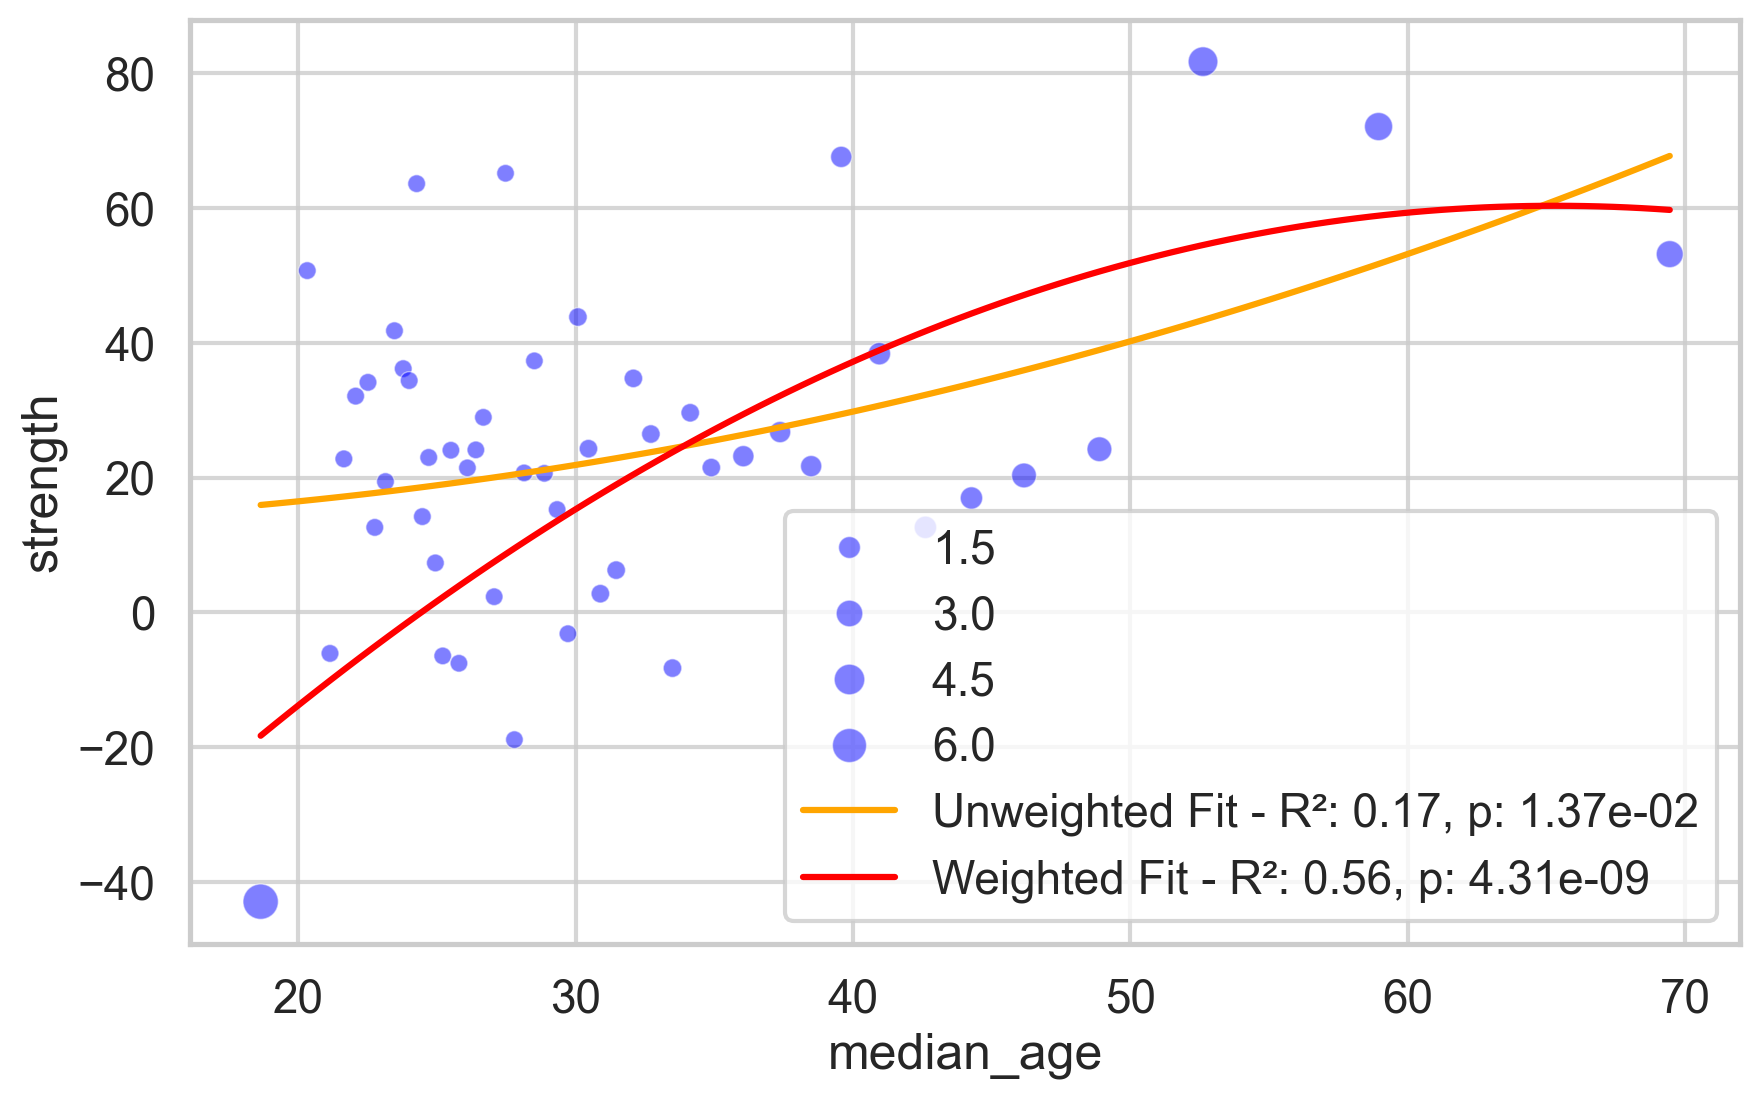

In [34]:
import seaborn as sns

i = vis_df.sort_values("quad_beta2", ascending=True).index[3]
row = vis_df.loc[i]
X_full = network_matrices.loc[network_matrices[region_col] == row[region_col]]
y = X_full[key]
age_vec = X_full["median_age"].astype(float)
X = sm.add_constant(age_vec)
# Fit the OLS model
unweighted = smf.ols(f"{key} ~ median_age + I(median_age ** 2)", data=X_full).fit()
weighted = smf.wls(f"{key} ~ median_age + I(median_age ** 2)", data=X_full, weights=X_full["weight"]).fit()
# Plot the regression results

plt.figure(figsize=(10, 6))
sns.scatterplot(x=age_vec, y=y, color="blue", size=X_full["weight"], alpha=0.5)


pred_age_vec = sm.add_constant(pd.DataFrame(np.linspace(age_vec.min(), age_vec.max(), 100), columns=["median_age"]))
sns.lineplot(
    x=pred_age_vec["median_age"],
    y=unweighted.predict(pred_age_vec),
    color="orange",
    label=f"Unweighted Fit - R²: {unweighted.rsquared:.2f}, p: {unweighted.f_pvalue:.2e}",
)
sns.lineplot(
    x=pred_age_vec["median_age"],
    y=weighted.predict(pred_age_vec),
    color="red",
    label=f"Weighted Fit - R²: {weighted.rsquared:.2f}, p: {weighted.f_pvalue:.2e}",
)

# sns.regplot(x=age_vec, y=y, scatter_kws={"s": 10}, line_kws={"color": "red"}, order=2)

In [ ]:
vmin = 0
vmax = 0.35
# vmin = -0.1
# vmax = 0.1

for hemi, hemi_data, key, vis_data in zip(
    ["L", "R"], [lh, rh], ["left", "right"], [data_lh, data_rh]
):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    p = Plot(
        hemi_data,
        # rh,
        # views="latmed",  # L-lat, L-med, R-lat, R-med
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",
        mirror_views=True,
        views=["medial", "lateral"],
    )

    # ---- main data layer -------------------------------------------------
    # If your metric is centred on 0 (e.g., t-values) use TwoSlopeNorm for symmetry
    # norm = TwoSlopeNorm(
    #     vmin=np.nanmin([data_lh, data_rh]), ,vmax=np.nanmax([data_lh, data_rh])
    # )

    p.add_layer(
        {"left": data_lh, "right": data_rh},
        cmap="Purples",
        color_range=(vmin, vmax),
        # color_range=(2.5,3.5),
        cbar_label=value_column,
    )
    # ---- outline layer ---------------------------------------------------
    # Re-use the label arrays; surfplot draws borders when as_outline=True
    p.add_layer({"left": lh_parc, "right": rh_parc}, cmap="gray", as_outline=True, cbar=False)

    # fig = p.build(cbar_kws=dict(location="bottom", decimals=2))
    fig = p.build()

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_{metric}_{hemi}_{value_column}.png", dpi=400)

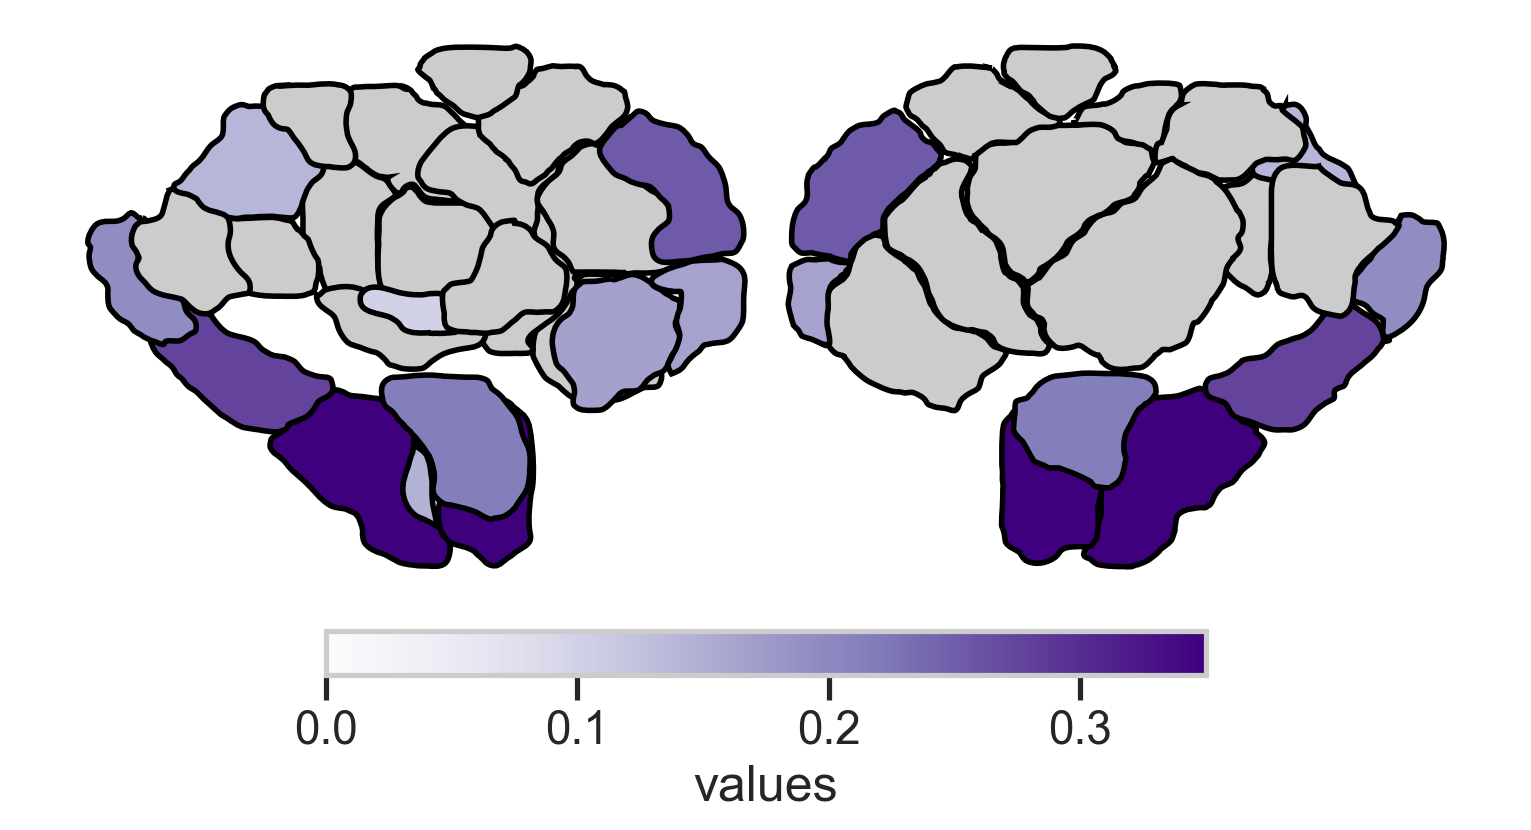

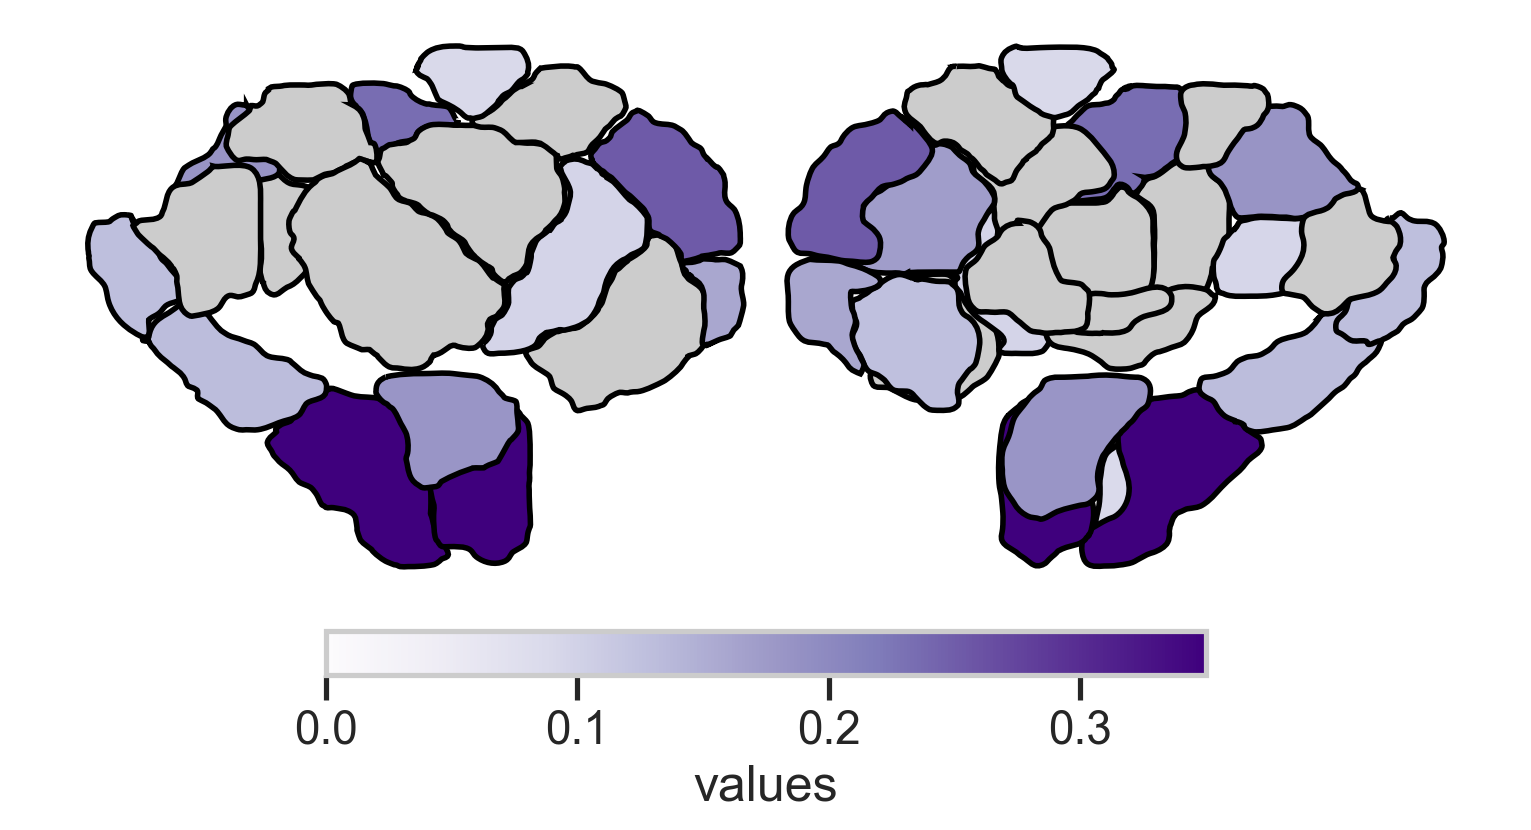

In [160]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L", "R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="Purples",
        line_color="black",
        line_thickness=2,
        vmin=vmin,
        vmax=vmax,
        show_figure=False,
    )

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)